In [134]:
from __future__ import division

from matplotlib import  pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from statsmodels.base.model import GenericLikelihoodModel
from statsmodels.discrete.count_model import ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, ZeroInflatedGeneralizedPoisson, Poisson, NegativeBinomialP
%matplotlib inline

np.random.seed(123456789)

In [184]:
pi = 0.3
lambda_ = 2.
N = 10000

inflated_zero = stats.bernoulli.rvs(pi, size=N)
x = (1 - inflated_zero) * stats.poisson.rvs(lambda_, size=N)

In [72]:
class MyPoisson(GenericLikelihoodModel):
    def __init__(self, endog, exog=None, **kwds):
        if exog is None:
            exog = np.zeros_like(endog)
            
        super(MyPoisson, self).__init__(endog, exog, **kwds)
    
    def nloglikeobs(self, params):
        lambda_ = params[0]

        return -np.log(stats.poisson.pmf(self.endog, lambda_))
    
    def fit(self, start_params=None, maxiter=10000, maxfun=5000, **kwds):
        if start_params is None:
            lambda_start = self.endog.mean()
            
            start_params = np.array([lambda_start])
            
        return super(MyPoisson, self).fit(start_params=start_params,
                                                    maxiter=maxiter, maxfun=maxfun, **kwds)

In [156]:
model = MyPoisson(x)
results = model.fit()

lambda_mle_p = results.params[0]
print lambda_mle_p

Optimization terminated successfully.
         Current function value: 1.681022
         Iterations: 11
         Function evaluations: 22
1.3847


In [170]:
model = ZeroInflatedPoisson(x, np.ones((len(x),1)), np.ones((len(x), 1)) )
results = model.fit()

print results.params

Optimization terminated successfully.
         Current function value: 1.576974
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
[-0.84428527  0.68306207]


In [177]:
x = -.84428527
lam = .68306207
print 1/(1+np.exp(-x))
print np.exp(lam)

0.3006330249115034
1.9799311472784147


In [191]:
def zip_pmf(x, pi=pi, lambda_=lambda_):
    if pi < 0 or pi > 1 or lambda_ <= 0:
        return np.zeros_like(x)
    else:
        return (x == 0) * pi + (1 - pi) * stats.poisson.pmf(x, lambda_)

In [192]:
class MyZeroInflatedPoisson(GenericLikelihoodModel):
    def __init__(self, endog, exog=None, **kwds):
        if exog is None:
            exog = np.zeros_like(endog)
            
        super(MyZeroInflatedPoisson, self).__init__(endog, exog, **kwds)
    
    def nloglikeobs(self, params):
        pi, lambda_ = params

        return -np.log(zip_pmf(self.endog, pi=pi, lambda_=lambda_))
    
    def fit(self, start_params=None, maxiter=10000, maxfun=5000, **kwds):
        if start_params is None:
            lambda_start = self.endog.mean()
            excess_zeros = (self.endog == 0).mean() - stats.poisson.pmf(0, lambda_start)
            
            start_params = np.array([excess_zeros, lambda_start])
            
        return super(MyZeroInflatedPoisson, self).fit(start_params=start_params,
                                                    maxiter=maxiter, maxfun=maxfun, **kwds)
    def predict(self, params, exog=None):
        pi, lambda_ = params
        return np.repeat((1-pi)*lambda_, len(exog))

In [193]:
model = MyZeroInflatedPoisson(x)
results = model.fit()

pi_mle_zip, lambda_mle_zip = results.params
print pi_mle_zip, lambda_mle_zip

Optimization terminated successfully.
         Current function value: 1.586895
         Iterations: 38
         Function evaluations: 75
0.3099178135400755 2.018405093738763


In [202]:
def zip_hurdle_pmf(x, pi=pi, lambda_=lambda_):
    if pi < 0 or pi > 1 or lambda_ <= 0:
        return np.zeros_like(x)
    else:
        zero_part = (x == 0) * stats.bernoulli.pmf(0, 1-pi)
        positive_part = (x > 0) * (1 - stats.bernoulli.pmf(0, 1-pi))/(1 - stats.poisson.pmf(0, lambda_)) * stats.poisson.pmf(x, lambda_)
        return zero_part + positive_part

In [203]:
class MyZeroInflatedPoissonHurdle(GenericLikelihoodModel):
    def __init__(self, endog, exog=None, **kwds):
        if exog is None:
            exog = np.zeros_like(endog)
            
        super(MyZeroInflatedPoissonHurdle, self).__init__(endog, exog, **kwds)
    
    def nloglikeobs(self, params):
        pi = params[0]
        lambda_ = params[1]

        return -np.log(zip_hurdle_pmf(self.endog, pi=pi, lambda_=lambda_))
    
    def fit(self, start_params=None, maxiter=10000, maxfun=5000, **kwds):
        if start_params is None:
            lambda_start = self.endog.mean()
            excess_zeros = (self.endog == 0).mean() - stats.poisson.pmf(0, lambda_start)
            
            start_params = np.array([excess_zeros, lambda_start])
            
        return super(MyZeroInflatedPoissonHurdle, self).fit(start_params=start_params,
                                                    maxiter=maxiter, maxfun=maxfun, **kwds)

In [204]:
model = MyZeroInflatedPoissonHurdle(x)
results = model.fit()

pi_mle_h, lambda_mle_h = results.params
print pi_mle_h, lambda_mle_h

Optimization terminated successfully.
         Current function value: 1.586895
         Iterations: 36
         Function evaluations: 73
0.4016059693643461 2.0184692369999357


In [196]:
zip_hurdle_pmf(0, pi_mle_h, 2.0)

0.4016059693643461

In [98]:
def plot_pmf(pmf, support, scale=1, linestyle='-', label=None):
    lo,hi = support
    r = np.arange(lo, hi+1)
    plt.plot(r, pmf(r)*scale, linestyle=linestyle, label=label)

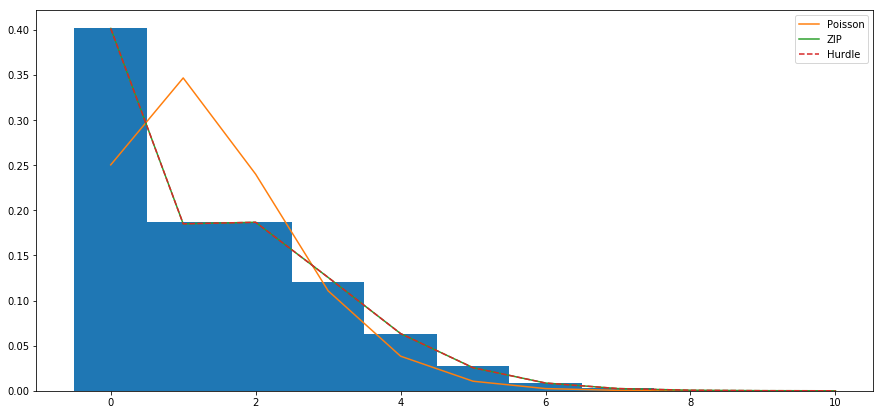

In [205]:
plt.rcParams['figure.figsize'] = [15,7]
plt.hist(x, bins=np.arange(len(set(x)))-.5, normed=True)
plot_pmf(lambda x: stats.poisson.pmf(x, lambda_mle_p), (np.min(x),np.max(x)), label='Poisson')
plot_pmf(lambda x: zip_pmf(x, pi=pi_mle_zip, lambda_=lambda_mle_zip), (np.min(x),np.max(x)), label='ZIP')
plot_pmf(lambda x: zip_hurdle_pmf(x, pi=pi_mle_h, lambda_=lambda_mle_h), (np.min(x),np.max(x)), linestyle='--', label='Hurdle')
plt.legend()

In [133]:
results.predict(np.zeros(5))

array([1.38470661, 1.38470661, 1.38470661, 1.38470661, 1.38470661])